In [1]:
import os
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import zipfile
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

import logging
from tqdm import tqdm
import pandas as pd
import json
from collections import defaultdict
import shutil

In [2]:
import kagglehub
kaggle_flickr8k_dataset_path = kagglehub.dataset_download("adityajn105/flickr8k")
print('Data source import complete.')

100%|██████████| 1.04G/1.04G [00:48<00:00, 23.0MB/s]

Extracting files...


Data source import complete.


In [3]:
#  to copy flickr8k_images
# Define source and destination paths
source_images_path = kaggle_flickr8k_dataset_path + "/Images"  # Replace with actual path
images_path = "/content/flickr8k_dataset/flickr8k_images" # Replace with your desired destination

# Check if the destination directory exists, if not create it
if not os.path.exists(images_path):
    os.makedirs(images_path)

# Copy the folder recursively
shutil.copytree(source_images_path, images_path, dirs_exist_ok=True)

print(f"Successfully copied flickr8k_images to {images_path}")

Successfully copied flickr8k_images to /content/flickr8k_dataset/flickr8k_images


In [4]:
print(f"Length of image directory: {len(os.listdir(images_path))}")

Length of image directory: 8091


In [5]:
source_captions_path = kaggle_flickr8k_dataset_path + "/captions.txt"  # Replace with actual path
destination_captions_path = "/content/flickr8k_dataset" # Replace with your desired destination


# Check if the destination directory exists, if not create it
if not os.path.exists(destination_captions_path):
    os.makedirs(destination_captions_path)
shutil.copy(source_captions_path, destination_captions_path)

print(f"Successfully copied captions to {destination_captions_path}")

Successfully copied captions to /content/flickr8k_dataset


In [6]:
#python
df = pd.read_csv("/content/flickr8k_dataset/captions.txt", delimiter=",")
df.columns = ['image', 'caption']
# 1. Add 'caption_number' and 'id' columns
df['caption_number'] = 0  # Initialize with 0
df['id'] = 0  # Initialize with 0
# 2. Assign unique 'id' to each unique image
unique_images = df['image'].unique()
image_id_mapping = {image: idx for idx, image in enumerate(unique_images)}
df['id'] = df['image'].map(image_id_mapping)
# 3. Assign occurrence numbers to 'caption_number'
df['caption_number'] = df.groupby('image').cumcount()
new_order = ['image','caption','caption_number','id']
df = df[new_order]
df = df.dropna()
df.to_csv("/content/flickr8k_dataset/captions.csv", index=False)
df.head()

,image,caption,caption_number,id
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,0,0
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,1,0
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,2,0
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,3,0
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,4,0


In [7]:
# Paths
images_path = "/content/flickr8k_dataset/flickr8k_images"  # Path to images
captions_file = "/content/flickr8k_dataset/captions.txt"  # Path to captions file
images_embeddings_file = "/content/flickr8k_dataset/image_embeddings.pt"
captions_embeddings_file = "/content/flickr8k_dataset/caption_embeddings.pt"

In [9]:
def setup_logging(log_directory="/content/flickr8k_dataset/", log_file="mmrcs8k.log"):
    """
    Set up logging configuration with both console and file handlers.
    Args:
        log_directory (str): Directory where the log file will be saved.
        log_file (str): The name of the log file.
    Returns:
        logger: Configured logger object.
    """
    # Ensure the log directory exists
    if not os.path.exists(log_directory):
        os.makedirs(log_directory)

    # Full log file path
    log_path = os.path.join(log_directory, log_file)
    # Create a custom logger
    logger = logging.getLogger()
    # First, remove all existing handlers to avoid duplication
    for handler in logger.handlers[:]:
        logger.removeHandler(handler)
    # Set the logging level to INFO
    logger.setLevel(logging.INFO)
    # Create handlers for file and console output
    file_handler = logging.FileHandler(log_path)
    console_handler = logging.StreamHandler()
    # Set the log level for handlers
    file_handler.setLevel(logging.INFO)
    console_handler.setLevel(logging.INFO)
    # Create a formatter and set it for both handlers
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(formatter)
    console_handler.setFormatter(formatter)
    # Add handlers to the logger
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)
    return logger
logger = setup_logging()

In [ ]:
#!rm -rf /content/flixke8k_dataset

In [10]:
# Load the pre-trained CLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
logger.info(device)
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

2025-02-14 07:01:31,234 - INFO - cuda
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
#!unzip /content/mmrcs-main.zip -d /content/

Archive:  /content/mmrcs-main.zip
dafaf2b3e1cee896126879a3100b29a935e54c5f
   creating: /content/mmrcs-main/
   creating: /content/mmrcs-main/flickr1k_dataset/
   creating: /content/mmrcs-main/flickr1k_dataset/Images/
  inflating: /content/mmrcs-main/flickr1k_dataset/Images/1000268201_693b08cb0e.jpg  
  inflating: /content/mmrcs-main/flickr1k_dataset/Images/1001773457_577c3a7d70.jpg  
  inflating: /content/mmrcs-main/flickr1k_dataset/Images/1002674143_1b742ab4b8.jpg  
  inflating: /content/mmrcs-main/flickr1k_dataset/Images/1003163366_44323f5815.jpg  
  inflating: /content/mmrcs-main/flickr1k_dataset/Images/1007129816_e794419615.jpg  
 extracting: /content/mmrcs-main/flickr1k_dataset/Images/1007320043_627395c3d8.jpg  
  inflating: /content/mmrcs-main/flickr1k_dataset/Images/1009434119_febe49276a.jpg  
  inflating: /content/mmrcs-main/flickr1k_dataset/Images/1012212859_01547e3f17.jpg  
  inflating: /content/mmrcs-main/flickr1k_dataset/Images/1015118661_980735411b.jpg  
  inflating: /con

In [11]:
def preprocess_and_save_image_embeddings(images_path, images_embeddings_file, processor, model, device, batch_size=16):
    """
    Preprocess images, generate embeddings, and save all in a single file.

    Args:
        images_path (str): Path to the directory containing image files.
        images_embeddings_file (str): Path to save the combined embeddings file.
        processor: Pretrained image processor (e.g., CLIPProcessor).
        model: Pretrained model to generate image embeddings (e.g., CLIPModel).
        device (str): Device to perform computation on ('cuda' or 'cpu').
        batch_size (int): Number of images to process in a batch.
    """
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    if not image_files:
        logger.warning("No image files found in the specified directory.")
        return

    all_embeddings = []
    image_filenames = []

    for i in tqdm(range(0, len(image_files), batch_size), desc="Processing Images"):
        batch_files = image_files[i:i+batch_size]

        try:
            images = [Image.open(os.path.join(images_path, img)).convert("RGB") for img in batch_files]
            inputs = processor(images=images, return_tensors="pt", padding=True).to(device)

            with torch.no_grad():
                embeddings = model.get_image_features(**inputs)
                embeddings = embeddings / embeddings.norm(dim=-1, keepdim=True)  # Normalize

            all_embeddings.append(embeddings.cpu())
            image_filenames.extend(batch_files)

        except Exception as e:
            logger.error(f"Error processing batch {i // batch_size + 1}: {e}")

    # Save all embeddings in one file
    torch.save(torch.cat(all_embeddings), images_embeddings_file)

    # Save filenames mapping
    with open(images_embeddings_file.replace('.pt', '_filenames.json'), 'w') as f:
        json.dump(image_filenames, f)

    logger.info(f"All image embeddings saved in: {images_embeddings_file}")

In [12]:
preprocess_and_save_image_embeddings(images_path, images_embeddings_file, processor, model, device)

Processing Images: 100%|██████████| 506/506 [01:22<00:00,  6.12it/s]
2025-02-14 07:03:20,628 - INFO - All image embeddings saved in: /content/flickr8k_dataset/image_embeddings.pt


In [13]:
def load_captions(df):
    df["image"] = df["image"].str.strip()
    df["caption"] = df["caption"].str.strip()
    captions_dict = defaultdict(list)  # Dictionary to store image -> list of captions
    for _, row in df.iterrows():
        image_name = row["image"]
        caption_text = row["caption"]
        captions_dict[image_name].append(caption_text)  # Store caption under the image

    return captions_dict  # Return a dictionary, not a list

In [14]:
dataframe = pd.read_csv("/content/flickr8k_dataset/captions.csv")
dataframe.head()
captions = load_captions(df)

In [15]:
def preprocess_and_save_caption_embeddings(captions, captions_embeddings_file, processor, model, device, batch_size=16):
    """
    Generate and save text embeddings in a single file.

    Args:
        captions (dict): Dictionary with image names as keys and lists of captions as values.
        captions_embeddings_file (str): Path to save the combined embeddings file.
        processor: The text processor for tokenizing captions.
        model: The model used for generating text embeddings.
        device: The device (CPU or GPU) to use for computation.
        batch_size (int): Number of captions to process in a batch.
    """
    all_captions = []
    caption_filenames = []

    for image_name, caption_list in captions.items():
        for i, caption in enumerate(caption_list, start=1):
            all_captions.append(caption)
            caption_filenames.append(f"{image_name}_{i}")

    all_embeddings = []

    for start in tqdm(range(0, len(all_captions), batch_size), desc="Processing Captions"):
        end = start + batch_size
        batch_captions = all_captions[start:end]

        try:
            inputs = processor(text=batch_captions, return_tensors="pt", padding=True, truncation=True, max_length=77).to(device)

            with torch.no_grad():
                text_features = model.get_text_features(**inputs)
                text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)

            all_embeddings.append(text_features.cpu())

        except Exception as e:
            logger.error(f"Error processing batch {start}-{end}: {e}")

    # Save all embeddings in one file
    torch.save(torch.cat(all_embeddings), captions_embeddings_file)

    # Save filenames mapping
    with open(captions_embeddings_file.replace('.pt', '_filenames.json'), 'w') as f:
        json.dump(caption_filenames, f)

    logger.info(f"All caption embeddings saved in: {captions_embeddings_file}")

In [16]:
preprocess_and_save_caption_embeddings(captions, captions_embeddings_file, processor, model, device)

Processing Captions: 100%|██████████| 2529/2529 [00:29<00:00, 85.71it/s]
2025-02-14 07:04:21,482 - INFO - All caption embeddings saved in: /content/flickr8k_dataset/caption_embeddings.pt


In [17]:
def compute_similarity_and_accuracy(image_embeddings_list, captions_embeddings_list, image_embeddings_dict, captions_embeddings_dict):
    """
    Compute similarity between image and caption embeddings and calculate accuracy.

    Args:
        image_embeddings_list (list): List of image embeddings as tensors.
        captions_embeddings_list (list): List of caption embeddings as tensors.
        image_embeddings_dict (dict): Mapping from image embeddings to filenames.
        captions_embeddings_dict (dict): Mapping from caption embeddings to filenames.

    Returns:
        float: Accuracy percentage.
    """
    # Check if the lists are empty
    if len(image_embeddings_list) == 0 or len(captions_embeddings_list) == 0:
        logger.error("Embedding lists are empty. Ensure embeddings are loaded correctly.")
        return 0.0

    try:
        # Convert lists of embeddings to numpy arrays
        image_embeddings_matrix = np.vstack(image_embeddings_list)
        captions_embeddings_matrix = np.vstack(captions_embeddings_list)

        # Normalize the embeddings to unit vectors
        image_embeddings_matrix_normalized = image_embeddings_matrix / np.linalg.norm(image_embeddings_matrix, axis=1, keepdims=True)
        captions_embeddings_matrix_normalized = captions_embeddings_matrix / np.linalg.norm(captions_embeddings_matrix, axis=1, keepdims=True)

        # Compute the cosine similarity matrix
        similarity_matrix = np.dot(image_embeddings_matrix_normalized, captions_embeddings_matrix_normalized.T)
        logger.info(f"Similarity matrix shape: {similarity_matrix.shape}")

        # Find the index of the highest similarity for each image embedding
        max_similarity_ids = np.argmax(similarity_matrix, axis=1)
        logger.info(f"Max similarity indices: {max_similarity_ids}")
        if max_id >= len(captions_embeddings_dict) or idx >= len(image_embeddings_dict):
          logger.error(f"Index mismatch: image index {idx} or caption index {max_id} not found in dictionaries.")


        # Log lengths of embeddings and dictionaries for debugging
        logger.info(f"Length of image embeddings list: {len(image_embeddings_list)}")
        logger.info(f"Length of image embeddings dictionary: {len(image_embeddings_dict)}")

        # Calculate accuracy by comparing filenames directly
        accuracy_list = []
        for idx, max_id in enumerate(max_similarity_ids):
            # Get filenames from the dictionaries using the indices
            image_filename = image_embeddings_dict[idx]  # Get image filename by index
            caption_filename = captions_embeddings_dict[max_id]  # Get caption filename by index

            # Compare the filenames to check if they match
            accuracy_list.append(1 if image_filename == caption_filename else 0)

        # Compute and return the accuracy
        accuracy = np.mean(accuracy_list) * 100 if accuracy_list else 0.0
        logger.info(f"Accuracy: {accuracy:.2f}%")
        return accuracy

    except Exception as e:
        logger.error(f"Error in computing similarity and accuracy: {e}")
        return 0.0


In [18]:
def load_embeddings(embeddings_file):
    """
    Load embeddings and corresponding filenames from a single file.

    Args:
        embeddings_file (str): Path to the embeddings file.

    Returns:
        filenames (list): List of filenames.
        embeddings (Tensor): Tensor containing all embeddings.
        embeddings_dict (dict): Mapping from embeddings to filenames.
    """
    #embeddings = torch.load(embeddings_file)
    embeddings = torch.load(embeddings_file, weights_only=True)

    filenames_file = embeddings_file.replace('.pt', '_filenames.json')
    with open(filenames_file, 'r') as f:
        filenames = json.load(f)

    print(len(filenames))

    #embeddings_dict = {str(emb.tolist()): filename for emb, filename in zip(embeddings, filenames)}

    embeddings_dict = {}
    for emb, filename in zip(embeddings, filenames):
      key = str(filename)  # Use filename as key
      if key in embeddings_dict:
        embeddings_dict[key].append(emb.tolist())  # Append to list
      else:
        embeddings_dict[key] = [emb.tolist()]  # Create a list for multiple embeddings

    print(len(embeddings_dict))

    return filenames, embeddings, embeddings_dict

In [19]:
# Load image and caption embeddings
image_filenames_list, image_embeddings_list, image_embeddings_dict = load_embeddings(images_embeddings_file)
captions_filenames_list, captions_embeddings_list, captions_embeddings_dict = load_embeddings(captions_embeddings_file)
logger.info(f"Loaded {len(image_embeddings_list)} image embeddings and {len(captions_embeddings_list)} caption embeddings.")
accuracy = compute_similarity_and_accuracy(image_embeddings_list, captions_embeddings_list, image_embeddings_dict, captions_embeddings_dict)
logger.info(f'Accuracy: {accuracy:.2f}%')

8091
8091
40455


2025-02-14 07:04:48,105 - INFO - Loaded 8091 image embeddings and 40455 caption embeddings.


40455


2025-02-14 07:04:50,141 - INFO - Similarity matrix shape: (8091, 40455)
2025-02-14 07:04:50,252 - INFO - Max similarity indices: [19514 15331   747 ... 36626 14930 11526]
2025-02-14 07:04:50,254 - ERROR - Error in computing similarity and accuracy: cannot access local variable 'max_id' where it is not associated with a value
2025-02-14 07:04:50,261 - INFO - Accuracy: 0.00%


In [20]:
# Function to get embeddings for text using CLIP
def get_query_embedding(query_string):
    inputs = processor(text=query_string, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        text_embedding = model.get_text_features(**inputs)
    return text_embedding / torch.norm(text_embedding)  # Normalize

In [21]:
# Function to get embeddings for Image using CLIP
def get_image_embedding(image_path):
    image = Image.open(image_path).convert("RGB")  # Ensure image is in RGB mode
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        image_embedding = model.get_image_features(**inputs)
    return image_embedding / torch.norm(image_embedding)

In [22]:
# Function to display top images with their ranks and scores
def display_images(top_images, images_path):
    # Create a figure with enough subplots to display images
    num_images = len(top_images)
    cols = 3  # You can change this based on how many images you want in a row
    rows = (num_images + cols - 1) // cols  # Calculate rows needed based on the number of images

    plt.figure(figsize=(20, 3 * rows))  # Adjust the size of the figure based on number of images

    for i, img_info in enumerate(top_images):
        # Ensure the filename has the .jpg extension (if not, add it)
        filename = img_info['item']

        if not filename.endswith('.jpg'):
          filename = filename.replace('.pt', '.jpg')
        # Path to the image file
        image_path = os.path.join(images_path, filename)

        # Open the image
        try:
            img = Image.open(image_path)
            ax = plt.subplot(rows, cols, i + 1)
            ax.imshow(img)
            ax.set_title(f"Rank {i + 1}: {filename} (Score: {img_info['score']:.4f})")
            ax.axis('off')
        except Exception as e:
            logger.error(f"Error loading image {filename}: {e}")

    plt.tight_layout()
    plt.show()

In [35]:
def display_image(image_path):
  img = Image.open(image_path)
  plt.figure(figsize=(2, 2))
  plt.imshow(img)
  plt.axis("off")  # Hide axes
  plt.show()

In [23]:
def display_iteam(image_path):
  img = Image.open(image_path)
  plt.figure(figsize=(2, 2))
  plt.imshow(img)
  plt.axis("off")  # Hide axes
  plt.show()

In [24]:
def search_top_matches(query_input, embeddings_list, items_list, top_n, get_embedding_fn):
    """
    Generic function to search for top N matches based on cosine similarity.

    Parameters:
    - query_input (str or image_path): The input query (text caption or image path).
    - embeddings_list (list of Tensors): List of stored embeddings (image or caption).
    - items_list (list): List of items (image filenames or text captions).
    - top_n (int): Number of top matches to return.
    - get_embedding_fn (function): Function to get the embedding (e.g., get_image_embedding or get_query_embedding).

    Returns:
    - List of dictionaries with "item" and "score" keys.
    """
    # Get the query embedding and normalize it
    query_embedding = get_embedding_fn(query_input).to(device)
    query_embedding = query_embedding / torch.norm(query_embedding)

    # Convert list of embeddings into a tensor for batch processing
    embeddings_list = [torch.tensor(embedding) if not isinstance(embedding, torch.Tensor) else embedding for embedding in embeddings_list]
    embeddings_tensor = torch.stack(embeddings_list).to(device)

    # Normalize all stored embeddings
    embeddings_tensor = embeddings_tensor / torch.norm(embeddings_tensor, dim=1, keepdim=True)

    # Compute cosine similarity in batch
    similarities = torch.matmul(embeddings_tensor, query_embedding.T).squeeze()

    # Get indices of top N matches
    #top_indices = torch.argsort(similarities, descending=True)[:top_n]

    # Retrieve top matching items
    #top_matches = [{"item": items_list[i], "score": similarities[i].item()} for i in top_indices]

    # Get indices of top N+1 matches (to account for removing query itself)
    top_indices = torch.argsort(similarities, descending=True)

    # Retrieve top matching items, excluding the query image itself and scores >= 1
    top_matches = []
    query_index = items_list.index(query_input) if query_input in items_list else None  # Find query index if it exists

    for i in top_indices:
        if len(top_matches) >= top_n:
            break  # Stop once we have enough matches
        if query_index is not None and i == query_index:
            continue  # Skip the query image itself
        if similarities[i].item() >= 1:
            continue  # Skip matches with scores >= 1

        top_matches.append({"item": items_list[i], "score": similarities[i].item()})


    return top_matches

In [25]:
top_n = 1

2025-02-13 19:03:20,116 - INFO - Text---to---Image
2025-02-13 19:03:20,118 - INFO - A little girl is swinging in a baby swing on the playground
2025-02-13 19:03:20,119 - INFO - Top 1 images:
2025-02-13 19:03:20,166 - INFO - Rank 1: 2436081047_bca044c1d3.jpg (Score: 0.3380)


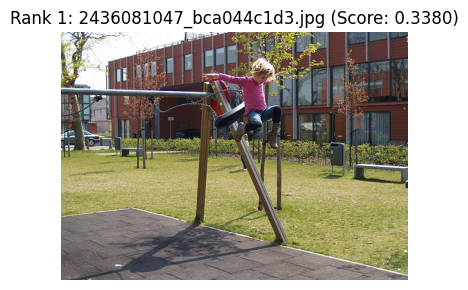

In [ ]:
#Search for the top images matching a given caption.
logger.info("Text---to---Image")
caption = "A little girl is swinging in a baby swing on the playground"
logger.info(f"{caption}")
logger.info(f"Top {top_n} images:")
top_images = search_top_matches(caption, image_embeddings_list, image_filenames_list,top_n,get_query_embedding)
# Print top 5 results
for idx, img in enumerate(top_images):
    logger.info(f"Rank {idx + 1}: {img['item']} (Score: {img['score']:.4f})")
display_images(top_images, images_path)

In [32]:
def captionToImage(caption):
  caption = "A little girl is swinging in a baby swing on the playground"
  logger.info(f"{caption}")
  logger.info(f"Top {top_n} images:")
  top_images = search_top_matches(caption, image_embeddings_list, image_filenames_list,top_n,get_query_embedding)
  image_name=top_images[0]['item']
  return image_name

2025-02-14 07:18:34,088 - INFO - A little girl is swinging in a baby swing on the playground
2025-02-14 07:18:34,090 - INFO - Top 1 images:


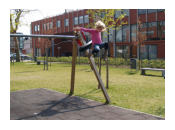

In [43]:
image_name=captionToImage("A little girl is swinging in a baby swing on the playground")
image_full_path = os.path.join(images_path, image_name)
display_iteam(image_full_path)

2025-02-13 19:03:28,124 - INFO - Image---to---Image


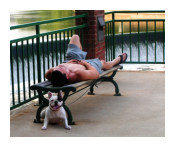

2025-02-13 19:03:28,169 - INFO - Top 1 images:
2025-02-13 19:03:28,230 - INFO - Rank 1: 3227594168_3351722aae.jpg (Score: 0.7709)


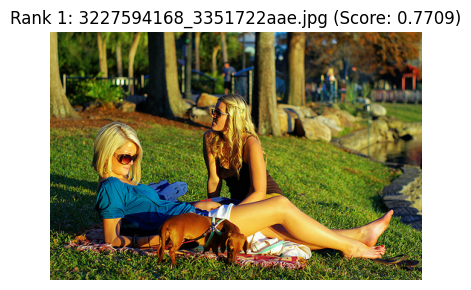

In [ ]:
# #Search for the top images matching a given image.
logger.info("Image---to---Image")
image_name ="1003163366_44323f5815.jpg"
image_path = os.path.join(images_path, image_name)
display_iteam(image_path)
logger.info(f"Top {top_n} images:")
top_images = search_top_matches(image_path, image_embeddings_list, image_filenames_list,top_n,get_image_embedding)
# Print top 5 results
for idx, img in enumerate(top_images):
    logger.info(f"Rank {idx + 1}: {img['item']} (Score: {img['score']:.4f})")
# Set path to images
display_images(top_images, images_path)

In [ ]:
dataframe = pd.read_csv("/content/flickr8k_dataset/captions.csv")
dataframe.head()

,image,caption,caption_number,id
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,0,0
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,1,0
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,2,0
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,3,0
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,4,0


In [ ]:
#Search for the top captions matching a given caption.
logger.info("Caption---to---Captions")
query_string = "A little girl is swinging in a baby swing on the playground ."
logger.info(f"{query_string}")
logger.info(f"Top {top_n} Captions:")
top_captions = search_top_matches(query_string,captions_embeddings_list,captions_filenames_list,top_n,get_query_embedding)
# Print top 5 results
#print(dataframe['caption'])
for i, item in enumerate(top_captions):
    caption=item['item']
    base_name, number = caption.rsplit('_', 1)
    match = dataframe[(dataframe['image'] == base_name) & (dataframe['caption_number'] == int(number))]
    # Return the 'caption' column of the matched row
    caption_text = match['caption'].iloc[0] if not match.empty else None
    print(caption_text)


2025-02-13 19:35:03,634 - INFO - Caption---to---Captions
2025-02-13 19:35:03,636 - INFO - A little girl is swinging in a baby swing on the playground .
2025-02-13 19:35:03,637 - INFO - Top 1 Captions:


a young girl swings on a swing .


2025-01-31 14:33:35,432 - INFO - Image---to---Captions


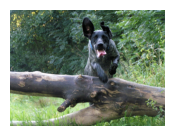

2025-01-31 14:33:35,485 - INFO - Top 5 images:
2025-01-31 14:33:35,631 - INFO - 1.A mottled black and grey dog in a blue collar jumping over a fallen tree ., Score: 0.3663
2025-01-31 14:33:35,632 - INFO - 2.A black dog leaps over a log ., Score: 0.3603
2025-01-31 14:33:35,636 - INFO - 3.A dog is jumping over a log with ears flying and tongue out ., Score: 0.3576
2025-01-31 14:33:35,638 - INFO - 4.A large black dog leaps a fallen log ., Score: 0.3504
2025-01-31 14:33:35,641 - INFO - 5.A dog is jumping over a log in a wooded area while carrying another log ., Score: 0.3468


In [ ]:
#Search for the top captions matching a given image.
logger.info("Image---to---Captions")
image_name = "1015584366_dfcec3c85a.jpg"
image_path = os.path.join(images_path, image_name)
display_iteam(image_path)
logger.info(f"Top {top_n} images:")
top_captions = search_top_matches(image_path,captions_embeddings_list,captions_filenames_list,top_n,get_image_embedding)
# Print top 5 results
for i, item in enumerate(top_captions):
    caption=item['item']
    caption=caption.replace('.jpg_', '.jpg#').replace('.pt', '')
    logger.info(f"{i+1}.{captions[caption]}, Score: {item['score']:.4f}")


In [ ]:
def imageToCaptions(image_name):
  logger.info("Image---to---Captions")
  #image_name="36979.jpg"
  image_path = os.path.join(images_path, image_name)
  display_iteam(image_path)
  logger.info(f"Top {top_n} images:")
  top_captions = search_top_matches(image_path,captions_embeddings_list,captions_filenames_list,top_n,get_image_embedding)
  caption = top_captions[0]['item']
  return caption

2025-02-13 19:50:35,789 - INFO - Image---to---Captions


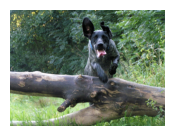

2025-02-13 19:50:35,841 - INFO - Top 1 images:


1015584366_dfcec3c85a.jpg_4


In [ ]:
image_name = "1015584366_dfcec3c85a.jpg"
caption=imageToCaptions(image_name)
print(caption)

In [ ]:
!zip -r flickr8k_dataset.zip /content/flickr8k_dataset

Streaming output truncated to the last 5000 lines.
  adding: content/flickr8k_dataset/flickr8k_images/3416246113_1745559b6b.jpg (deflated 0%)
  adding: content/flickr8k_dataset/flickr8k_images/2255332561_3375897ff0.jpg (deflated 0%)
  adding: content/flickr8k_dataset/flickr8k_images/1459032057_97e73ed6ab.jpg (deflated 0%)
  adding: content/flickr8k_dataset/flickr8k_images/3484842724_ef1124c87a.jpg (deflated 0%)
  adding: content/flickr8k_dataset/flickr8k_images/1207159468_425b902bfb.jpg (deflated 1%)
  adding: content/flickr8k_dataset/flickr8k_images/2190227737_6e0bde2623.jpg (deflated 0%)
  adding: content/flickr8k_dataset/flickr8k_images/143552697_af27e9acf5.jpg (deflated 0%)
  adding: content/flickr8k_dataset/flickr8k_images/3600909823_ce72c26e66.jpg (deflated 2%)
  adding: content/flickr8k_dataset/flickr8k_images/3240014971_ee2ea8406f.jpg (deflated 0%)
  adding: content/flickr8k_dataset/flickr8k_images/2549968784_39bfbe44f9.jpg (deflated 0%)
  adding: content/flickr8k_dataset/flick

# New Section